# The Pinhole Camera
* Closely follows Chapter 14 of the text "Computer Vision: Models, Learning, and Inference" by Simon Prince
* Purely geometric model
* Example problem: sparse stereo reconstruction
    * Two images
    * Found the same points within the images
    * Figure out the 3D position of the points
    
* Applications
    * 3D Navigation
    * Autonomous vehicles
    * Object recognition

## The Pinhole Camera (14.1)

<img src="images/Prince_Fig_14.2.jpg" width="500"/>

* Chamber with small hole in front
* Image is inverted on the back of the box
    * Called the __image plane__
* Goal: build a mathematical model of this process

__Virtual Image__

* It's a little inconvenient that the image is inverted (upside down)
* We can consider a __virtual image__ instead that would result from having the image be in front of the pinhole
    * Same distance from the hole
* Physically impossible, but conceptually useful
* A construct often used to indicate the camera orientation
* Mathematically equivalent to true pinhole model 
    * Axes aren't inverted, though
* This is usually how it is drawn

<img src="images/Prince_Fig_14.3.jpg" width="500"/>

__Terminology__

* __Optical center__: the point at which the rays converge
    * The pinhole itself
    * Often uses as the origin of the 3d world coordinate frame/system
* __Image plane__: Plane on which the virtual image in front of the pinhole is created
* __Principal point__: Point where a line from the optical center intersects with the image plane at a 90 degree angle
* __Optical Coordinate System__:
    * Points are represented as $p = [u,v,w]^{T}$
        * $w$ is along the __optical axis__ from the optical center through the principal point of the image plane
        * $v$ is down
        * $u$ is to the right
        * Right handed coordinate frame
    * Note that my notation differs slightly from the book because I'm not using boldface to denote vectors, and therefore can't overload letters
        * I use $p$ for the 3D world vector, rather than a bold $w$, for example
        * I use $q$ to denote the pixel location vector, rather than a bold $x$
* __Focal length__: Distance from the optical center to the principal point

__Generative Model__

* Much of image processing, signal processing, and computer vision is based on __generative models__
* We develop a statistical model of what we observe based on the thing we are interested in
* Suppose we are interested in a 3D point $p = [u,v,w]^{T}$
* We build a model of what we will observe, say $q = [x,y]^T$, representing the pixel location in the image
* Specifically, we can build a likelihood $p(q|p)$
* Light transport is deterministic, but we still use probability models to represent uncertainties
    * Noise in the sensor
    * Quantization noise of pixel locations
    * Unmodeled factors, such as lense effects
* Nonetheless, to understand the geometry, we'll start with a deterministic model
* Our goal: determine where a ray of light from $p$ will land on our image - the pixel coordinates $q$
* Essentially, where does a ray of light strike the image plane?
* Called __perspective projection__

* To build up our model, we'll start simple and add complexity

### The Normalized Camera (14.1.1)

<img src="images/Prince_Fig_14.4.jpg" width="500"/>

* __Normalized camera__: Pinhole camera with a focal length of 1
* Origin of pixel coordinate frame is at the principal point
* See 2D slice in Figure 14.4 (above)
    * $u$ and $x$ axes point out of the page/white board
* Should be apparent that for a 3D point $p=[u,v,w]^T$, the pixel values will be<br>
\begin{align*}
    x & = \frac{u}{w} \\
    y &= \frac{v}{w} 
\end{align*}
    * Note that for now the units are all physical units (e.g., mm)

#### Relationship to Homogenous Coordinates
- Note that this matches up perfectly with the homogeneous coordinates that we studied earlier
- The third parameter represents the unknown range to the object
    - Put differently, all points $p = \alpha [u,v,w]^T$ are along the same ray that runs from the optical center through $[u,v,w]^T$
    - The image coordinates are the same regardless of $\alpha$, or equivalently, regardless of $w$


### Focal Length Parameters (14.1.2)

* Two problems
    * Real cameras do not have a focal length of one
    * Image is measured in pixels - not physical distance
* Both of these essentially result in a scaling factor on $x$ and $y$<br>
* The photoreceptors may have a different spacing along the $x$ and $y$ axes
    * Depends on the camera
    * No reason to assume it's necessarily the same
* Results in different scaling factors for the two axes<br>
\begin{align}
    x & = \frac{\phi_x u}{w} \\
    y &= \frac{\phi_y v}{w}
    \text{\hspace{999em}}
\end{align}
* Called the __focal length parameters__
* But this is misleading, not just for the focal length
* Also accounts for the photreceptor spacing





### Offset and Skew Parameters (14.1.3)

* Generally, origin of images is not at the princiapl point
* Almost always in the top left corner of the image
* Thus, we need offset parameters as well:<br>
\begin{align*}
    x & = \frac{\phi_x u}{w} + \delta_x \\ 
    y &= \frac{\phi_y v}{w} + \delta_y 
\end{align*}
* $\delta_x$ and $\delta_y$ are the offsets from the top-left corner to the principal point
    * Could think of as $(\delta_x,\delta_y)$ is the location of the principal point in pixels
* Normally you would expect this at the center of the image
    * Book makes a small error here
    * States that if $640 \times 480$ VGA, the principal point will be at $(x,y) = (320,240)$
    * However, this would require that the pixel boundaries are at integer values, rather than pixel centers
    * Most of the time pixel centers occur at integer values, e.g., $(x,y) = (0,0)$, $(x,y) = (1,2)$, etc.
    * This means in the example above the midpoint would actually be at a pixel boundary of $(319.5,239.5)$
* In practice, manufacturers may not make cameras where the principal point is perfectly centered
* Often best to estimate the parameter

__Skew__
* The coordinate system of pixels may also not be perfectly orthogonal
* Can account for this with a skew term $\gamma$
* The resulting camera model is<br>
\begin{align*}
    x & = \frac{\phi_x u + \gamma v}{w} + \delta_x \\
    y &= \frac{\phi_y v}{w} + \delta_y 
\end{align*}
* Collectively these are called the __intrinsic parameters__ of the camera<br>
$\{\phi_x,\phi_y,\gamma,\delta_x,\delta_y\}$
* We can store in a matrix <br>
\begin{equation*}
    \Lambda = 
    \begin{bmatrix}
    \phi_x & \gamma & \delta_x \\
    0 & \phi_y & \delta_y \\\
    0 & 0 & 1
    \end{bmatrix}
\end{equation*}
* This is useful for reasons that will become clear shortly


### Position and Orientation of Camera (14.1.4)

* Our coordinate system is centered at the optical center
* The orientation is determined by the camera
* This coordinate system may not be conveient or suitable
* Ideally, we could use any world coordinate system that we like
    * For example, North-West-Up or North-East-Down
    * Both are right-handed coordinate systems like we're used to
* Need a system that is common to more than one camera (or camera position)
* In general, we can change from one 3D coordinate system to another with a rotation and offset <br>
\begin{align*}
    \begin{bmatrix}
        u' \\
        v' \\
        w'
    \end{bmatrix}
    &=
    \begin{bmatrix}
        \omega_{11} & \omega_{12} & \omega_{13} \\
        \omega_{21} & \omega_{22} & \omega_{23} \\
        \omega_{31} & \omega_{32} & \omega_{33} 
    \end{bmatrix}
    \begin{bmatrix}
    u \\
    v \\
    w
    \end{bmatrix}
    +
    \begin{bmatrix}
        \tau_x \\
        \tau_y \\
        \tau_z
    \end{bmatrix}\\
    p' &= \Omega p + \tau
\end{align*}
* $p'$ is the transformed point from the world coordinate system to the camera coordinate system
* $\Omega$ is a $3\times3$ rotation matrix
    * Orthonormal: $\Omega \Omega^T = I = \Omega^T \Omega$
    * Just 3 degrees of freedom
* $\tau$ is a translation vector
* Collectively called the __extrinics parameters__ of the camera<br>
$\{\Omega,\tau\}$
* Esssentially the camera __pose__ = orientation & position


### Full Pinhole Camera Model (14.1.5)
* If we combine the two we get a full camera model

\begin{align*}
    x &= \frac{\phi_x(\omega_{11}u + \omega_{12}v + \omega_{13}w + \tau_x) + \gamma(\omega_{21}u + \omega_{22}v + \omega_{23}w + \tau_y)}{\omega_{31}u + \omega_{32}v + \omega_{33}w + \tau_z} + \delta_x \\
    y &= \frac{\phi_y(\omega_{21}u + \omega_{22}v + \omega_{23}w + \tau_y)}{\omega_{31}u + \omega_{32}v + \omega_{33}w + \tau_z} + \delta_y 
\end{align*}

* We can now abbreviate the full model with<br>
$q = \mathrm{pinhole}[p,\Lambda,\Omega,\tau]$
* In practice, this won't be perfect
* To model the unknown effects, we can use the central limit theorem and use a Gaussian distribution<br>
\begin{equation}
    \mathrm{Pr}(q|p,\Lambda,\Omega,\tau) = \mathcal{N}\left(\mathrm{pinhole}[p,\Lambda,\Omega,\tau],\sigma^2 I\right)
\end{equation}
* Again, this is a generative model
* Likelihood of observing a 2D image point q given the 3D world point $p$ and the parameters $\{\Lambda,\Omega,\tau\}$

### Radial Distortion (14.1.6)
* Real-world cameras rarely match the pinhole
* Usually have multiple lenses
* Collect light from larger area
* Creates deviations from pinhole
    * Example: some parts out of focus
    * No longer map world point to single point
* __Radial distortion__ is a nonlinear warping on distance from center
* Happens in practice when field of view is large
    * Fish-eye cameras
* Commonly modeled as a polynomial of the distance from the center (principal point) of the image
    * Even powers only to preserve even symmetry as function of $r$
* Applied 
    * After perspective projection (division by $w$) 
    * Before effect of intrinsic parameters
        * Warping must be relative to the optical axis (principal point) and not the image coordinates

\begin{align*}
    p' &= 
    \begin{bmatrix}
        u' \\
        v' \\
        w'
    \end{bmatrix} \\
    r &\triangleq \sqrt{\left(\frac{u'}{w'}\right)^2 + \left(\frac{v'}{w'}\right)^2} \\
    x'' &= x'(1 + \beta_1 r^2 + \beta_2 r^4)\\
    y'' &= y'(1 + \beta_1 r^2 + \beta_2 r^4)
\end{align*}

## Maximum Likelihood Overview
* Suppose we have a probability density function (PDF) $p(x)$ of some random variable $x$
* Say this PDF depends on some parameters $\theta$, so we can represent the pdf as $p(x|\theta)$
    * This is not a conditional probability
        * $\theta$ is not a random variable
    * Sometimes the notation $p(x;\theta)$ is used instead to emphasize that $\theta$ is not a random variable
* Let's also assume the parameters are deterministic (not random variables), but unknown
* How should we estimate the parameters?
* Common choices
    * Minimize some measure of error
    * Maximum likelihood
* Maximum likelihood is a common choice<br>
\begin{equation*} 
    \hat{\theta} = \underset{\theta}{\mathrm{arg \thinspace max}} \thickspace p(x|\theta)
\end{equation*}

### Why use maximum likelihood?
* Think of $p(x|\theta)$ as evaluated at some fixed $x$ where $\theta$ is the variable<br>
\begin{equation*} 
    l(\theta) \triangleq p(x|\theta)
\end{equation*}
* We call this the __likelihood__
* By definition, the maximum likelihood (ML) estimate is ... most likely
    * Sounds good, but is this just a definition
* Viewed differently, this is the parameter value that maximizes the PDF at the observed value of $x$
    * Is most consistent with the data
    * Is the value that makes $x$ most probable
* Often we have an additive noise model in which the Central Limit Theorem often applies, which means $p(x|\theta)$ has a normal distribution (aka Gaussian distribution)
\begin{align*}
    x &= \hat{x}(\theta) + w 
\end{align*}
where $w$ is noise with a Gaussian distribution
* In this scenario, maximum likelihood often ends up being equivalent to minimum mean squared error
\begin{align*}
    \hat{\theta} &= \underset{\theta}{\mathrm{arg \thinspace max}} (x - \hat{x}(\theta))^2 
\end{align*}
* Most importantly, there is a bound on the mean squared error known as the Cramer-Rao lower bound (CRLB)
* If an unbiased estimator exists that attains the CRLB, it is the maximum likelihood estimate
* There is no other estimator that will have a smaller MSE
* Thus, if MSE is an appropriate measure of agreement, we really like maximum likelihood estimators

### Log Likelihood
* Generally we often calculate the joint likelihood of a large set of random variables
* Often the random variables are independent of one another
* In this case, the joint probability nicely factors
* For example, consider the joint PDF of a bunch of observations of locations of features<br>
\begin{equation}
    p(q_1,q_2,\dots,q_I) = p(q_1) p(q_2) \cdots p(q_I) = \prod_{i=1}^{I} p(q_i)
\end{equation}
* Note that PDFs are always non-negative
* This means the log is real
* Since the log is monotonically increase<br>
\begin{equation}
    \hat{\theta} = \underset{\theta}{\mathrm{arg \thinspace max}} \thickspace p(x|\theta) = \underset{\theta}{\mathrm{arg \thinspace max}} \thickspace \ln p(x|\theta)
\end{equation}
* But why would we want to take the log?
* Two reasons
    * Converts the product of marginal probabilities into a sum of log of the probabilities<br>
    \begin{equation}
        \ln \prod_{i=1}^{I} p(x_i|\theta) = \sum_{i=1}^{I} \ln p(x_i|\theta) 
    \end{equation}
    * We often have probabilities that have exponentials, where the exponent is a polynomial
    * Applies to the normal distribution
    * The log conerts a Gaussian into MSE<br>
    \begin{align}
        p(x) &= \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left[-\frac{\left(x-\mu_x\right)^2}{2\sigma^2}\right]  \\
        \ln p(x) &= -\ln\left(\sqrt{2\pi\sigma^2}\right) - \frac{\left(x-\mu_x\right)^2}{2\sigma^2}
    \end{align}

## Three Geometric Problems (14.2)
* Three important geometric problems
* Problems first, (approximate) solutions later

### Problem 1: Learning Extrinsic Parameters (14.2.1)
* Recover position and orientation of camera relative to a known scene
* Sometimes called the 
    * __Perspective-n-point (PnP)__ problem
    * __Exterior oreintation__ problem
* Specifically say we are given a known object
    * Know $I$ distinct 3D points $\{p_i\}_{i=1}^{I}$
    * Their image coordinates $\{q_i\}_{i=1}^{I}$
    * Intrinsic parameters $\Lambda$
* Goal: estimate rotation $\Omega$ and translation $\tau$<br>
\begin{equation}
    \hat{\Omega},\hat{\tau} = \underset{\Omega,\tau}{\mathrm{arg \thinspace max}} \left[\sum_{i=1}^{I} \ln\left[\mathrm{p}(q_i|p_i,\Lambda,\Omega,\tau)\right]\right] 
\end{equation} 
as much as possible
* Our goal is to find the extrinsic parameters that make the expected and actual pixel locations of the point agree

### Problem 2: Learning Intrinsic Parameters (14.2.2)
* Estimate parameters $\Lambda$
* Same criteria
    * Make the points where 3D points hit a camera with known pose (extrinsic parameters) match the actual observed points
* Process is more commonly known as __calibration__
* Critical if we want to infer/estimate anything about the 3D world from 2D images
* Specifically say we are given a known object
    * Know $I$ distinct 3D points $\{p_i\}_{i=1}^{I}$
    * Their image coordinates $\{q_i\}_{i=1}^{I}$
* Goal: estimate the intrinsic parameters<br>
\begin{equation}
    \hat{\Lambda} = \underset{\Lambda}{\mathrm{arg \thinspace max}} \left\{\underset{\Omega,\tau}{\max} \left[\sum_{i=1}^{I} \ln\left[\mathrm{p}(q_i|p_i,\Lambda,\Omega,\tau)\right]\right]\right\} 
\end{equation}
* Note that this requires simultaneous estimates of the extrinsic parameters
* In general, the extrinsic parameters are never just known
    * The camera could be in any particular pose
* We don't really care about the extrinsic parameters
    * But we have to estimate them to estimate the intrinsic parameters
    * Generally, parameters that have to be estimated but aren't of interest are called __nuisance parameters__
* Often special __calibration targets__ are used to create a known 3D object
* OpenCV is designed to work with checkerboards, for example


### Problem 3: Inferring 3D World Points (14.2.3)
* We cannot estimate a 3D point with a single camera in a single position
* There is an ambiguity about how far the ray of light is from the camera
* Suppose we have $J\geq2$ cameras
    * Or equivalently, images captured from the same scene from different positions
* This means we must be able to identify points as seen in different images $\{q_j\}_{j=1}^{J}$
* This is why it was so important to have feature detectors and descriptors that were invariant to changes in perspective
* If $J=2$ called __stereo reconstruction__ 
* If $J>2$ called __multiview reconstruction__
* Many applications
    * Autonomous vehicle navigation
    * 3D object reconstruction
* Specifically say we are given $J$ calibrated cameras with known poses
    * For each camera, we know $(\Lambda,\Omega,\tau)$
    * We have the 2D projections $\{q_j\}_{j=1}^{J}$ of the same points from each of the cameras
* Then estimate the 3D locations of all of the points<br> 
    
    \begin{equation} 
        \{\hat{p}_i\}_{i=1}^{I} = \underset{\{p_i\}_{i=1}^{I}}{\mathrm{arg \thinspace max}} \left[\sum_{i=1}^{I} \ln\left[\mathrm{p}(q_i|p_i,\Lambda,\Omega,\tau)\right]\right] 
    \end{equation} 

* Known as __triangulation__

### Problem 4: Inferring Extrinsic Parameters & 3D World Points 
* This is __Simultaneous Localization and Mapping (SLAM)__
* Not covered in Chapter 14 of the text
* In practice, we need to estimate the extrinsic parameters (localization) at the same time that we estimate the 3D point locations<br>
    
    \begin{equation*} 
        \hat{\Omega},\hat{\tau},\{\hat{p}_i\}_{i=1}^{I} = \underset{\Omega,\tau,\{p_i\}_{i=1}^{I}}{\mathrm{arg \thinspace max}} \left[\sum_{i=1}^{I} \ln\left[\mathrm{p}(q_i|p_i,\Lambda,\Omega,\tau)\right]\right]
    \end{equation*}

* Discussed in Chapter 16
* Will also discuss approach used by SLAM algorithms


### Solving the Problems (14.2.4)
* Four geometric problems
* Each is an inference problem
* Each forumlated in terms of maximum likelihood
* Produces a nonlinear optimization problem
* There are many optimization algorithms
    * Entire classes are taught on this subject
    * See appendix of text for some examples
* Key limitations
    * Local minima
    * Computation required
* All of the optimization algorithms converge towards a local minimum
* The good ones do it quickly and efficiently (computationally)
* But how do we avoid a poor local minima?
* Initialize the algorithm near a really good minimum 
    * Preferably the global minimum
* The remainder of this lecture is about getting these good initial estimates
* Based on different objective functions
    * Not the maximum likelihood
        * Something else
    * Why?
        * Perhaps we can develop objective functions that can be optimized in closed form
        * With solutions near the true solution (globabl minimum)
    * Why do we care about closed form? 
        * Fast (iterations not necessary)
        * No problems with local minima

## Homogeneous Coordinates (14.3)

### Motivation
* These are kind of a trick
* Remember what motivated the Laplace and $z$ Transforms?
    * Enabled us to solve ordinary constant-coffieficient differential/difference equations efficiently
    * Turned these equations into algrebra problems
* We use complex numbers and complex exponentials for similar reasons
* Homogenous coordinates enable us to transform nonlinear problems into linear problems
* Linear problems can often be solved in closed form
* These aren't really the *right* problems
    * Different optimization criteria
* But they are close enough to initialize the nonlinear optimization of the true cost function

### Mathematical Representations

#### 2D Points
\begin{equation} \tilde{q} = \lambda 
    \begin{bmatrix} 
        x \\ 
        y \\ 
        1
    \end{bmatrix} 
\end{equation}

* We convert a 2D point $q$ into a __homogeneous coordinate__ $\tilde{q}$
* $\lambda$ is an arbitrary scaling factor
* Redundant representation
    * $\lambda$ could be anything
* $\tilde{q} = [2,4,2]^{T}$ and $\tilde{q} = [3,6,3]^T$ both represent $q = [1,2]^T$
    * Scaling factors of $\lambda=2$ and $\lambda=3$ were used
* Converting between homogeneous and Cartesian coordinates is simple
    * To homogeneous: append a 1
    * To Cartesian: divide the first two elements by the third element
* Example for $\tilde{q} = [\tilde{x},\tilde{y},\tilde{z}]^T$<br>
\begin{align}
    x &= \frac{\tilde{x}}{\tilde{z}} & y &= \frac{\tilde{y}}{\tilde{z}}
\end{align}
* Equivalent to capturing the same rays of light at different distances (see Figure 14.11)
    * $\lambda$ represents the unknown depth, as measured by the optical axis coordinate
        * Note this is different than the range to the point: $r = \sqrt{x^2 + y^2 + z^2}$
        * However, is equivalent:<br>
        \begin{equation}
            r = \sqrt{(\lambda x)^2 + (\lambda y^2) + \lambda^2} 
        = \lambda \sqrt{x^2 + y^2 + 1}
        \end{equation}
    * Also turns out to be the same as capturing the same ray with cameras of varying focal lengths
        * The location of $(x,y)$ scale with the focal length in the same way they scale with the depth

#### 3D Points

* We can do the same thing with 3D world points $p$
* We represent as 4D homogenous vectors $\tilde{q}$<br>
\begin{equation}
    \tilde{q} = \lambda \begin{bmatrix} u \\ v \\ w \\ 1 \end{bmatrix} 
\end{equation}
* Where $\lambda$ is an arbitrary scaling factor
* Conversion is essentially the same as the 2D case

### Camera Model in Homogenous Coordinates (14.3.1)

* Hard to understand why we're going through this trouble until we re-examine the pinhole camera model<br>
\begin{align}
    x &= \frac{\phi_x u}{w} + \delta_x & y = \frac{\phi_y v}{w} + \delta_y
\end{align}
* Here we're assuming the world point $p = [u,v,w]^T$ is in the same coordinate system as the camera
* Note that this is a nonlinear function of $p$ because of the division by $w$
* In homogenous coordinates, this becomes linear!<br>
\begin{equation}
    \lambda 
    \begin{bmatrix} 
        x \\ 
        y \\ 
        1 
    \end{bmatrix} =
    \begin{bmatrix}
        \phi_x & \gamma & \delta_x & 0 \\
        0 & \phi_y & \delta_y & 0 \\
        0 & 0 & 1 & 0
    \end{bmatrix}
    \begin{bmatrix}
        u \\ 
        v \\ 
        w \\ 
        1
    \end{bmatrix}
\end{equation}
* If we multiply this out for each row, we get<br>
\begin{align*}
    \lambda x &= \phi_x u + \gamma v + \delta_x w \\
    \lambda y &= \phi_y v + \delta_y w \\
    \lambda &= w
\end{align*}
* We can solve for $x$ and $y$ by converting back to Cartesian coordinates
* Divide the first two equations by the third
* Gets us back to the pinhole model

* Using homogenous coordinates side-steps the nonlinear part of the projection process
* This operation is saved until the very end
* Everything up to that point is now linear

* We can now fairly easily add the extrinsic parameters into the equation

\begin{equation*}
    \lambda 
    \begin{bmatrix} 
        x \\ 
        y \\ 
        1 
    \end{bmatrix} =
    \begin{bmatrix}
        \phi_x & \gamma & \delta_x & 0 \\
        0 & \phi_y & \delta_y & 0 \\
        0 & 0 & 1 & 0
    \end{bmatrix}
    \begin{bmatrix}
        \omega_{11} & \omega_{12} & \omega_{13} & \tau_x\\
        \omega_{21} & \omega_{22} & \omega_{23} & \tau_y\\
        \omega_{31} & \omega_{32} & \omega_{33} & \tau_z\\
        0 & 0 & 0 & 1
    \end{bmatrix}
    \begin{bmatrix}
        u \\ 
        v \\ 
        w \\ 
        1
    \end{bmatrix}
    =
    \begin{bmatrix}
        \phi_x & \gamma & \delta_x  \\
        0 & \phi_y & \delta_y \\
        0 & 0 & 1 
    \end{bmatrix}
    \begin{bmatrix}
        \omega_{11} & \omega_{12} & \omega_{13} & \tau_x\\
        \omega_{21} & \omega_{22} & \omega_{23} & \tau_y\\
        \omega_{31} & \omega_{32} & \omega_{33} & \tau_z\\
    \end{bmatrix}
    \begin{bmatrix}
        u \\ 
        v \\ 
        w \\ 
        1
    \end{bmatrix} 
\end{equation*}

* In matrix form this becomes
\begin{equation*}
    \lambda \tilde{q} = 
    \begin{bmatrix}
        \Lambda & 0 
    \end{bmatrix}
    \begin{bmatrix}
        \Omega & \tau \\ 0^T & 1
    \end{bmatrix}
    \tilde{p} 
\end{equation*}
* Or even more simply

\begin{equation}
    \lambda \tilde{q} =  \Lambda 
        \begin{bmatrix}
            \Omega & \tau 
        \end{bmatrix} 
        \tilde{p}
\end{equation}

* Solving the four problems in homogenous coordinates is much easier
* Provides good initial estimates for the nonlinear optimization problems
* Will go through these next


## Learning Extrinsic Parameters (14.4)

* Suppose we have 
    * A known object with $I$ distinct 3D points $\{p_i\}_{i=1}^{I}$
    * Thier projections in the image $\{q_i\}_{i=1}^{I}$
    * Camera instrinsic parameters $\Lambda$
* In homogenous coordinates the image point $\tilde{q}_i$ is given by<br>

\begin{equation}
    \lambda \begin{bmatrix} 
        x_i \\ 
        y_i \\ 
        1 
    \end{bmatrix} =
    \begin{bmatrix}
        \phi_x & \gamma & \delta_x  \\
        0 & \phi_y & \delta_y  \\
        0 & 0 & 1 
    \end{bmatrix}
    \begin{bmatrix}
        \omega_{11} & \omega_{12} & \omega_{13} & \tau_x\\
        \omega_{21} & \omega_{22} & \omega_{23} & \tau_y\\
        \omega_{31} & \omega_{32} & \omega_{33} & \tau_z\\
    \end{bmatrix}
    \begin{bmatrix}
        u_i \\ 
        v_i \\ 
        w_i \\ 
        1
    \end{bmatrix} 
\end{equation}

* Let us first discard the effect of the intrinsic parameters $\Lambda$
* Premultiply both sides by the inverse of this matrix to produce<br>

\begin{equation}
    \lambda_i 
    \begin{bmatrix} 
        x'_i \\ y'_i \\ 1 
    \end{bmatrix} =
    \begin{bmatrix}
        \omega_{11} & \omega_{12} & \omega_{13} & \tau_x\\
        \omega_{21} & \omega_{22} & \omega_{23} & \tau_y\\
        \omega_{31} & \omega_{32} & \omega_{33} & \tau_z
    \end{bmatrix}
    \begin{bmatrix}
        u_i \\ v_i \\ w_i \\ 1
    \end{bmatrix} 
\end{equation}

* The transformed coordinate $\tilde{x}' = \Lambda^{-1} \tilde{x}$ are called __normalized image coordinates__
* They are what we would have seen with a normalized camera
* Note that $\lambda_i$ can be determined from the last equation <br>

\begin{equation}
    \lambda_i = \omega_{31}u_i + \omega_{32}v_i + \omega_{33} w_i + \tau_z 
\end{equation}

* If we substitute this back into the first two equations we get<br>

\begin{equation}
    \begin{bmatrix}
        (\omega_{31}u_i + \omega_{32}v_i + \omega_{33} w_i + \tau_z)x'_i \\
        (\omega_{31}u_i + \omega_{32}v_i + \omega_{33} w_i + \tau_z)y'_i 
    \end{bmatrix} =
    \begin{bmatrix}
        \omega_{11} & \omega_{12} & \omega_{13} & \tau_x\\
        \omega_{21} & \omega_{22} & \omega_{23} & \tau_y\\
    \end{bmatrix}
    \begin{bmatrix}
        u_i \\ v_i \\ w_i \\ 1
    \end{bmatrix}
\end{equation}

* For known points $p_i$ and $q_i$, these are now linear in the unknown extrinsic parameters that we wish to estimate, 
$\Omega$ and $\tau$
* If we have $I$ pairs of points in the world and image
* We can create a linear system of equations<br>

\setcounter{MaxMatrixCols}{20}

\begin{align*}    
    \begin{bmatrix}
           u_1 &    v_1 &    w_1 &      1 &      0 &      0 &      0 &      0 & -u_1 x'_1 & -v_1 x'_1 & -w_1 x'_1 &  -x'_1 \\
           0   &    0   &      0 &      0 &    u_1 &    v_1 &    w_1 &      1 & -u_1 y'_1 & -v_1 y'_1 & -w_1 y'_1 &  -y'_1 \\
           u_2 &    v_2 &    w_2 &      1 &      0 &      0 &      0 &      0 & -u_2 x'_2 & -v_2 x'_2 & -w_2 x'_2 &  -x'_2 \\
           0   &    0   &      0 &      0 &    u_2 &    v_2 &    w_2 &      1 & -u_2 y'_2 & -v_2 y'_2 & -w_2 y'_2 &  -y'_2 \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots &    \vdots &    \vdots &    \vdots & \vdots \\
           u_I &    v_I &    w_I &      1 &      0 &      0 &      0 &      0 & -u_I x'_I & -v_I x'_I & -w_I x'_I &  -x'_I \\
             0 &      0 &      0 &      0 &    u_I &    v_I &    w_I &      1 & -u_I y'_I & -v_I y'_I & -w_I y'_I &  -y'_I
    \end{bmatrix}
    \begin{bmatrix}
        \omega_{11} \\ 
        \omega_{12} \\ 
        \omega_{13} \\ 
        \tau_x\\
        \omega_{21} \\ 
        \omega_{22} \\ 
        \omega_{23} \\ 
        \tau_y\\
        \omega_{31} \\ 
        \omega_{32} \\ 
        \omega_{33} \\ 
        \tau_z
    \end{bmatrix}
    = 0
\end{align*}

* This is a linear equation in the unknown parameters $A b = 0$
* Known as the __minimum direction problem__
    * This is not the maximum likelihood estimate of $\Omega$ and $\tau$
    * Rather, this is trying to enforce a constraint on the relationship in homogeneous coordinates
    * Very different optimization criterion
    * However, if there is no error, both are true
    * This means the constraint gets you to a reasonable starting point
* We want the value that minimizes $\|Ab\|^2$
    * Note the is the $L_2$ norm of $Ab$
    * Equivalent to the sum of squared elements of this vector
* This is more complicated than it seems
* Not all values are allowed
    * $\Omega$ must be a rotation matrix
    * This means it must be orthonormal
    * It cannot, for example, be $0$
* One way to constraint the problem is to put an arbitrary constraint $\|b\|^2 = 1$
    * Avoids the solution $b=0$
* The solution can be obtained by performing a singular value decomposition $A = U L V^T$, and setting $\hat{b}$ to be the last column of $V$ corresponding to the smallest singular value 
    * Diagonals of $L$
* However, this only gets us to the solution to within a scaling factor
* We need a true rotation matrix that is as close as possible to this estimate
* Known as the __orthogonal Procrustes problem__
* If from $b$ we create $\Omega$ and then apply another singular value decomposition such that $\Omega = U L V^T$, then the best estimate of $\Omega$ is given by<br>
\begin{equation}
    \hat{\Omega} = U V^T 
\end{equation}
* The scaling factor can then be estimated by taking the average across the 9 entries of $\Omega$<br>
\begin{equation}
    \hat{\tau} = \tau \left(\frac{1}{9} \sum_{m=1}^{3} \sum_{n=1}^{3} \frac{\hat{\Omega}_{mn}}{\Omega_{mn}}\right)
\end{equation}

* It's possible this will produce an estimate in which $\tau_z$ is negative
    * This would mean the object was behind the camera
* If this is the case, we can multiply our estimates of $\Omega$ and $\tau$ by $-1$

* "Scrappy" little algorithm
* Typical of methods in homogenous coordinates
* Might be inaccurate, but close enough to serve as a good starting point for the nonlinear optimization problem
    * Note that even this nonlinear optimization is a little tricky, since $\Omega$ must remain a valid rotation matrix

* This algorithm requires 11 equations to solve for the 12 unknowns
    * Keep in mind we have the constraint $\|b\|^2 = 1$ so $b$ only has 11 degrees of freedom
* Each point contributes two equations
* We need a minimum then of $I=6$ points to have the problem well conditioned
* Keep in mind there are really only 6 unknowns (rotation and translation)
* Minimal solution owuld only require $I=3$ points
* See literature or notes in text for these minimal solutions

## Learning Intrinsic Parameters (14.5)
* Known as __camera calibration__
* Based on viewing a known object, sometimes called a __calibration target__
* Specifically, suppose we have $I$ distinct 
    * 3D points $\{p_i\}_{i=1}^{I}$
    * Corresponding 2D projections $\{q_i\}_{i=1}^{I}$
* Ideally, we'd like to calculate the maximum likelihood estimates of the intrinsic parameters<br>
\begin{equation}
    \hat{\Lambda} = \underset{\Lambda}{\mathrm{arg \thinspace max}} \left\{\underset{\Omega,\tau}{\max} \left[\sum_{i=1}^{I} \ln\left[\mathrm{p}(q_i|p_i,\Lambda,\Omega,\tau)\right]\right]\right\}
\end{equation}

### Coordinate Ascent
* Alternate between estimating $(\Omega,\tau)$ and $\Lambda$
* Initialize with some reasonable value for the intrinsic parameters
    * Assume 
        * Same focal length and scalaing factors for $x$ and $y$ directions
        * Principal point is in the center of the image
        * No skew
    * Get camera calibration from others
    * Use a typical camera calibration matrix
    * Obtain the camera calibration from the manufacturer
1. Estimate Extrinsic Parameters<br>
\begin{equation}
    \hat{\Omega},\hat{\tau} = \underset{\Omega,\tau}{\mathrm{arg \thinspace max}} \left[\sum_{i=1}^{I} \ln\left[\mathrm{p}(q_i|p_i,\hat{\Lambda},\Omega,\tau)\right]\right] 
\end{equation}
using the methods described previously
2. Estimate Intrinsic Parameters<br>
\begin{equation}
    \hat{\Lambda} = \underset{\Lambda}{\mathrm{arg \thinspace max}} \left[\sum_{i=1}^{I} \ln\left[\mathrm{p}(q_i|p_i,\Lambda,\hat{\Omega},\hat{\tau})\right]\right] 
\end{equation} 

* This will get closer and closer to the correct solution
* We know how to solve the first problem
* How do we solve the second problem?

#### Intrinsic Parameter Estimation
* Given
    * 3D points $\{p_i\}_{i=1}^{I}$
    * Corresponding 2D projections $\{q_i\}_{i=1}^{I}$
    * Extrinsic parameters $(\Omega,\tau)$
* Estimate intrinsic parameters
* If we assume normal distribution, our goal is<br>
\begin{align}
    \hat{\Lambda} &= \underset{\Lambda}{\mathrm{arg \thinspace max}} \left[\sum_{i=1}^{I} \ln\left[\mathcal{N}\left(q_i-\mathrm{pinhole}[p_i,\Lambda,\Omega,\tau],\sigma^2 I\right)\right]\right]\\
    &= \underset{\Lambda}{\mathrm{arg \thinspace min}} \left[\sum_{i=1}^{I} \left(q_i-\mathrm{pinhole}[p_i,\Lambda,\Omega,\tau]\right)^T\left(q_i-\mathrm{pinhole}[p_i,\Lambda,\Omega,\tau]\right)\right]
\end{align} 
which is a least squares problem
* It turns out this is linear in the intrinsic parameters!
* We don't even need homogenous coordinates<br>
\begin{align}
    A_i &\triangleq 
    \begin{bmatrix}
        \frac{\omega_{11}u_i + \omega_{12}v_i + \omega_{13}w_i + \tau_x}{\omega_{31}u_i + \omega_{32}v_i + \omega_{33}w_i + \tau_z} & \frac{\omega_{21}u_i + \omega_{22}v_i + \omega_{23}w_i + \tau_y}{\omega_{31}u_i + \omega_{32}v_i + \omega_{33}w_i + \tau_z} & 1 & 0 & 0 \\
        0 & 0 & 0 & \frac{\omega_{21}u_i + \omega_{22}v_i + \omega_{23}w_i + \tau_y}{\omega_{31}u_i + \omega_{32}v_i + \omega_{33}w_i + \tau_z} & 1 
    \end{bmatrix} \\
    h & \triangleq 
    \begin{bmatrix}
        \phi_x \\
        \gamma\\
        \delta_x\\
        \phi_y\\
        \delta_y
    \end{bmatrix} 
\end{align}

Then our goal is <br>

\begin{equation}
    \hat{h} = \underset{h}{\mathrm{arg \thinspace min}} 
    \left[\sum_{i=1}^{I} (A_i h-x_i)^T (A_i h - x_i)\right]
\end{equation}

* This is a linear least squares problem
* There is a straight-forward closed form solution
* This step does actually maximize the likelihood, so long as we are working with a normal distribution

### Limitations 

* This iterative 2-step approach is great in principle
    * Simple
    * Easy (relatively) to implement
* Unfortunately convergence is slow
    * It requires many iterations (lots of computation)
* Better to use as an intialization
* Then can solve the original problem and optimize $(\Lambda,\Omega,\tau)$ jointly
    * There are good nonlinear optimization algorithms for this
    * Iterative and complicated, but more efficient once well initialized
* A bit more complicated than other optimization algorithms because of the constraints
    * $\Omega$ must be orthonormal (valid rotation matrix)
 

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import PSUCV as pcv

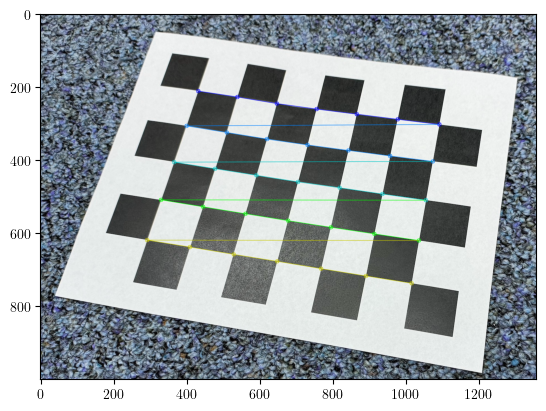

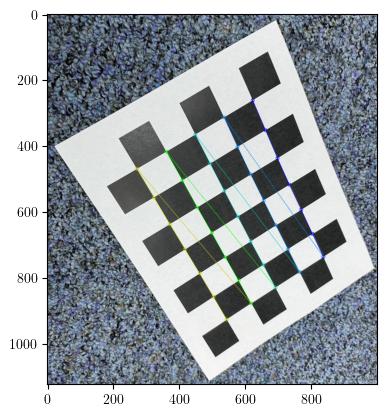

In [2]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# It is easier to treat the chessboard is stationary with the third coordinate fixed
# at 0 and modeling all differences as camera motion.
# Here, arbitrary units are used since the actual size of the chessboard is unknown.
n_rows = 5
n_cols = 7

objp = np.zeros((n_rows*n_cols,3), np.float32)
objp[:,:2] = np.mgrid[0:n_cols,0:n_rows].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
obj_points = [] # 3d point in real world space
img_points = [] # 2d points in image plane.

images = ['images/Board1.jpeg','images/Board2.jpeg']
for filename in images:
    image = cv.imread(filename)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    reprojection_error, corners = cv.findChessboardCorners(gray, (n_cols,n_rows), None)
    # If found, add object points, image points (after refining them)
    if reprojection_error == True:
        obj_points.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        img_points.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(image, (n_cols,n_rows), corners2, reprojection_error)
    plt.imshow(image)
    plt.show()

reprojection_error = 0.8964111981368302
camera_matrix = [[2.29350633e+03 0.00000000e+00 9.56929168e+02]
 [0.00000000e+00 2.52045320e+03 6.38106889e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion_coefficients = [[ 5.50654238e-02  4.24667351e+00 -1.74996434e-02  3.93539661e-02
  -2.22547054e+01]]
rotation_vectors = (array([[-0.56947775],
       [ 0.06477537],
       [ 0.16353221]]), array([[ 0.18506698],
       [-0.61416572],
       [ 1.05374119]]))
translation_vectors = (array([[-4.74924048],
       [-3.42813341],
       [20.67107592]]), array([[-3.49765509],
       [-3.48685965],
       [23.55120025]]))


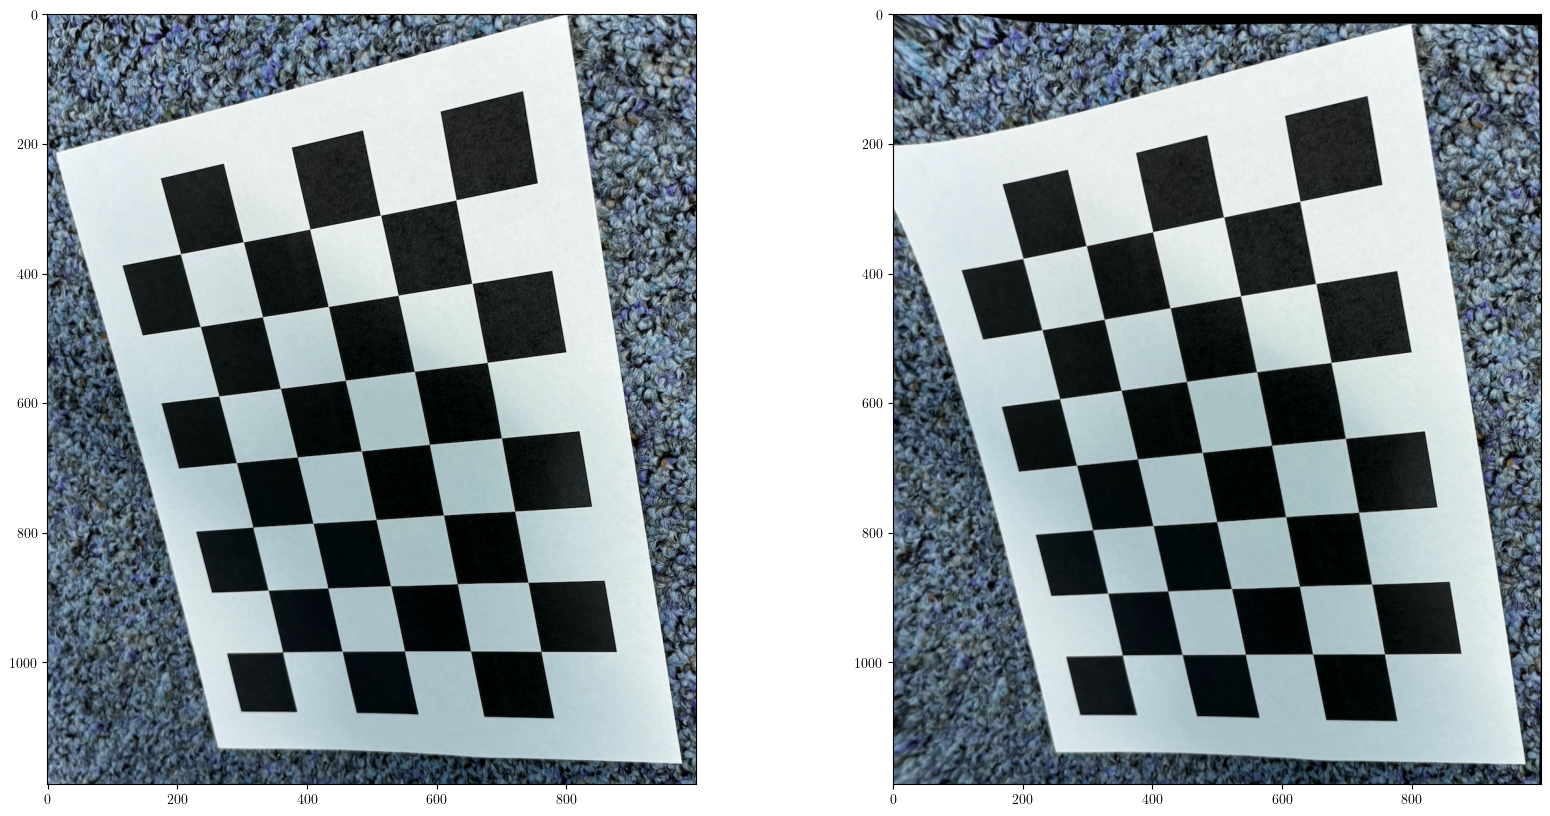

In [3]:
#%% Calibrate the Camera
# Calibrate the camera using the object points and image points
# The function returns both the intrinsic parameters (camera matrix, distortion coefficients)
# and the extrinsic parameters (rotation and translation vectors) in a tuple.
# The camera matrix mtx maps 3D points in the world coordinate frame to 2D points
# in the image plane. The distortion coefficients dist contain the radial and
# tangential distortion coefficients.
# The rotation vectors rvecs and translation vectors tvecs map points from the
# world coordinate frame to the camera coordinate frame.
image_size = gray.shape[::-1]
reprojection_error, camera_matrix, distortion_coefficients, rotation_vectors, translation_vectors = cv.calibrateCamera(obj_points, img_points, image_size, None, None)

print(f'reprojection_error = {reprojection_error}')
print(f'camera_matrix = {camera_matrix}')
print(f'distortion_coefficients = {distortion_coefficients}')
print(f'rotation_vectors = {rotation_vectors}')
print(f'translation_vectors = {translation_vectors}')

# Undistort the Image
# The function returns the undistorted image. The fourth argument is the output
# (undistorted) image, if provided. If not provided, the function creates a
# new image with the correct size and type.
image = cv.imread('images/Board3.jpeg')
undistorted = cv.undistort(image, camera_matrix, distortion_coefficients)

figure = plt.figure()
figure.clf()
figure.set_size_inches(20,10)

axes = figure.add_subplot(121)
axes.imshow(image)

axes = figure.add_subplot(122)
axes.imshow(undistorted)

plt.show()

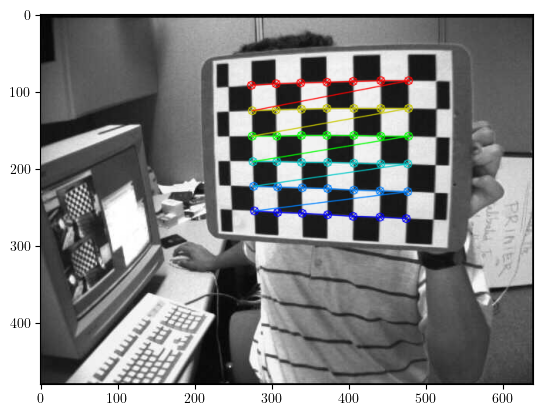

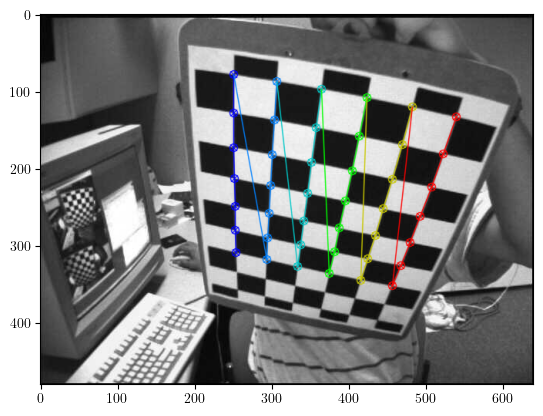

In [4]:
#%% Find the Chessboard Corners
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# It is easier to treat the chessboard is stationary with the third coordinate fixed
# at 0 and modeling all differences as camera motion.
# Here, arbitrary units are used since the actual size of the chessboard is unknown.
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
obj_points = [] # 3d point in real world space
img_points = [] # 2d points in image plane.
#images = glob.glob('*.jpg')
images = ['images/left01.jpg','images/left02.jpg']
#images = ['images/Board1.jpg','images/Board2.jpg']
for filename in images:
    image = cv.imread(filename)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    reprojection_error, corners = cv.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    if reprojection_error == True:
        obj_points.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        img_points.append(corners)
        # Draw and display the corners
        cv.drawChessboardCorners(image, (7,6), corners2, reprojection_error)
        plt.imshow(image)
        plt.show()

reprojection_error = 0.13770588324492505
camera_matrix = [[532.31551797   0.         339.8746808 ]
 [  0.         533.20299196 229.95766404]
 [  0.           0.           1.        ]]
distortion_coefficients = [[-2.74923327e-01 -1.16425943e-01  1.97353060e-03 -2.80934499e-04
   6.99029371e-01]]
rotation_vectors = (array([[-0.43225971],
       [ 0.25016797],
       [-3.08977599]]), array([[ 0.41089818],
       [ 0.6562471 ],
       [-1.3394641 ]]))
translation_vectors = (array([[ 3.84814001],
       [ 0.98297114],
       [14.81777053]]), array([[-2.08430788],
       [ 1.9142636 ],
       [12.77872996]]))


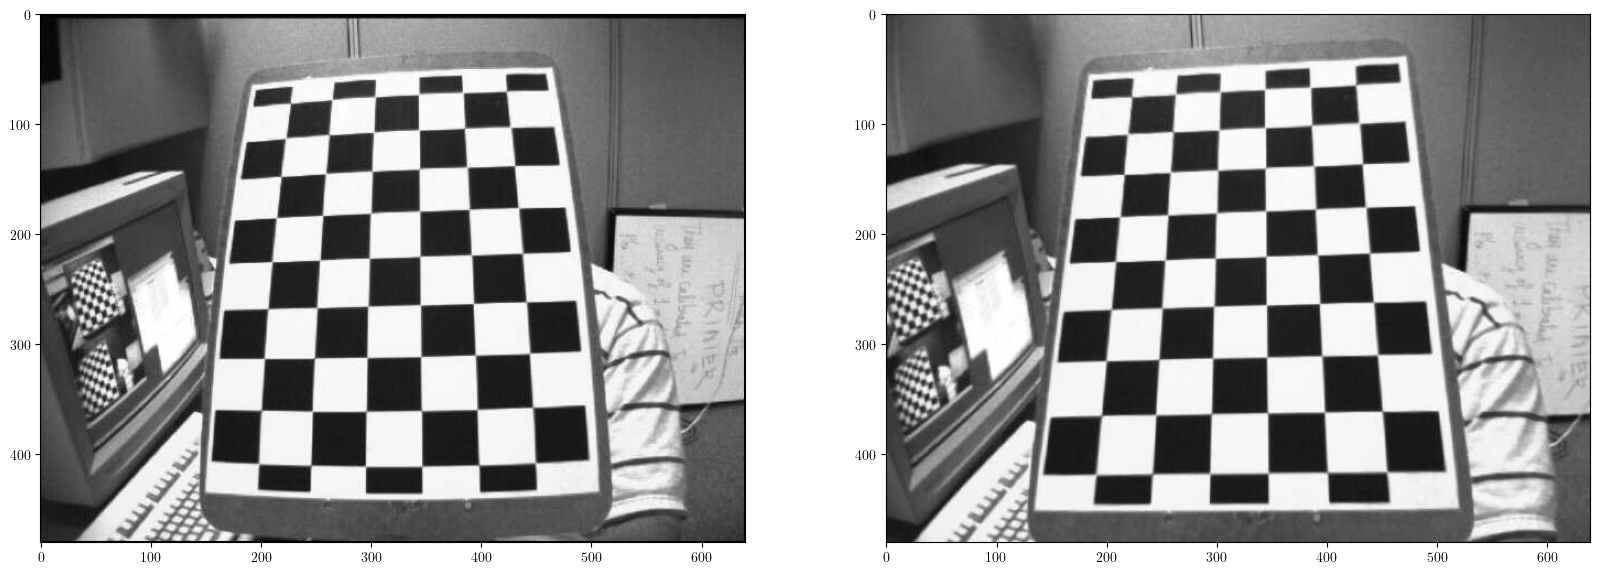

In [8]:
#%% Calibrate the Camera
# Calibrate the camera using the object points and image points
# The function returns both the intrinsic parameters (camera matrix, distortion coefficients)
# and the extrinsic parameters (rotation and translation vectors) in a tuple.
# The camera matrix mtx maps 3D points in the world coordinate frame to 2D points
# in the image plane. The distortion coefficients dist contain the radial and
# tangential distortion coefficients.
# The rotation vectors rvecs and translation vectors tvecs map points from the
# world coordinate frame to the camera coordinate frame.
image_size = gray.shape[::-1]
reprojection_error, camera_matrix, distortion_coefficients, rotation_vectors, translation_vectors = cv.calibrateCamera(obj_points, img_points, image_size, None, None)

print(f'reprojection_error = {reprojection_error}')
print(f'camera_matrix = {camera_matrix}')
print(f'distortion_coefficients = {distortion_coefficients}')
print(f'rotation_vectors = {rotation_vectors}')
print(f'translation_vectors = {translation_vectors}')

# Undistort the Image
# The function returns the undistorted image. The fourth argument is the output
# (undistorted) image, if provided. If not provided, the function creates a
# new image with the correct size and type.
image = cv.imread('images/left12.jpg')
undistorted = cv.undistort(image, camera_matrix, distortion_coefficients)

figure = plt.figure()
figure.clf()
figure.set_size_inches(20,10)

axes = figure.add_subplot(121)
axes.imshow(image)

axes = figure.add_subplot(122)
axes.imshow(undistorted)

plt.show()

## Inferring 3D World Points
* Finally the multiview reconstruction problem
* Now we have multiple ($J$) cameras, each with their own known parameters
* They are viewing the same point 
* Let us use a single index on a point to indicate the camera $\{x_j\}_{j=1}^{J}$
    * Later we will consider the $i$ th point as seen by the $j$ th camera and denote it as $x_{ij}$
* Ideally we would like to apply<br>
\begin{equation*} 
    \hat{p} = \underset{p}{\mathrm{arg \thinspace max}} \left[\sum_{j=1}^{J} \ln\left[\mathrm{p}(q_j|p,\Lambda,\Omega,\tau)\right]\right]
\end{equation*}
* Note that we are only considering a single point to simplify notation
    * We dropped the $i$ index
* However, now we have a $j$ index for the $J$ cameras

* This doesn't have a closed-form solution
* Let's have a look in homogenous coordinates
* Recall that in normalized image coordinates (pre-multiply both sides by $\Lambda^{-1}$ we have<br>
\begin{equation}
    \lambda_j \begin{bmatrix} x'_j \\ y'_j \\ 1 \end{bmatrix} =
    \begin{bmatrix}
    \omega_{11j} & \omega_{12j} & \omega_{13j} & \tau_{xj}\\
    \omega_{21j} & \omega_{22j} & \omega_{23j} & \tau_{yj}\\
    \omega_{31j} & \omega_{32j} & \omega_{33j} & \tau_{zj}\\
    \end{bmatrix}
    \begin{bmatrix}u \\ v \\ w \\ 1\end{bmatrix}
\end{equation}
<br>
where $x'_j$ and $y'_j$ are the normalized image coordinates for the $j\text{th}$ camera
* The last equation indicates that<br>
$\lambda_j = \omega_{31j} u + \omega_{32j} v + \omega_{33j} w + \tau_{zj}$
* If we substitute this into the equation above we get

\begin{equation*}
    \begin{bmatrix} 
        (\omega_{31j} u + \omega_{32j} v + \omega_{33j} w + \tau_{zj})x'_j \\ 
     (\omega_{31j} u + \omega_{32j} v + \omega_{33j} w + \tau_{zj})y'_j 
    \end{bmatrix} 
    =
    \begin{bmatrix}
        \omega_{11j} & \omega_{12j} & \omega_{13j} & \tau_{xj}\\
        \omega_{21j} & \omega_{22j} & \omega_{23j} & \tau_{yj}
    \end{bmatrix}
    \begin{bmatrix} 
        u \\ 
        v \\ 
        w \\ 
        1 
    \end{bmatrix}
\end{equation*}

* This can then be re-arranged
    * Provides two linear constraints
        * This makes sense intuitively
        * For every point, we are able to determine its $x$ and $y$ pixel coordinates (2 constraints), but we do not know how far the ray is from the camera
    * Three unknowns $(u,v,w)$
    * Is thus an under-determined problem
        * Infinite perfect solutions
        * Does not get better as we consider more points - actually worsens
        * For every point, we get 3 unknowns and only 2 constraints
    
\begin{equation}
    \begin{bmatrix}
    (\omega_{31j}x'_j-\omega_{11j}) & (\omega_{32j}x'_j-\omega_{12j}) & (\omega_{33j}x'_j-\omega_{13j}) \\
    (\omega_{31j}y'_j-\omega_{21j}) & (\omega_{32j}y'_j-\omega_{22j}) & (\omega_{33j}y'_j-\omega_{23j}) 
    \end{bmatrix}
    \begin{bmatrix}
    u \\ v \\ w 
    \end{bmatrix}
    = 
    \begin{bmatrix}
    \tau_{xj} - \tau_{zj}x'_j \\
    \tau_{uj} - \tau_{zj}y'_j 
    \end{bmatrix}
\end{equation}

* With multiple cameras, we can add more equations (rows) for the same point
    * Each camera adds two constraints
* Can then solve for $p$ in a least squares sense
* Note this is a different criterion than maximizing the likelihood
    * Not quite the solution we're after
    * But good way to initialize
    
### Limitations
* Requires that we have found the same points in images from multiple cameras
    * Called __correspondence__
    * May not be as simple as matching up features by descriptors
    * May be from a very different point of view and thereby may have very different descriptors
    * To be discussed (Chapter 16)
* Requires intrinsic and extrinsic parameters